<a href="https://colab.research.google.com/github/MiraSharma8511/Hands-on-DiffusionModel/blob/main/1%20Basics%20of%20Diffusion%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.8 MB/s eta 0:00:00


In [3]:
import torch
import torchvision
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
dataset = torchvision.datasets.MNIST(root = "mnist/", train=True, download=True,transform=torchvision.transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11476747.46it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 365634.16it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3189217.45it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5107380.37it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [6]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([7, 8, 9, 8, 4, 7, 6, 0])


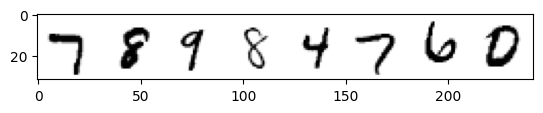

In [7]:
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

In [8]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
    return x * (1 - amount) + noise * amount

Amount ----> tensor([0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571, 1.0000])


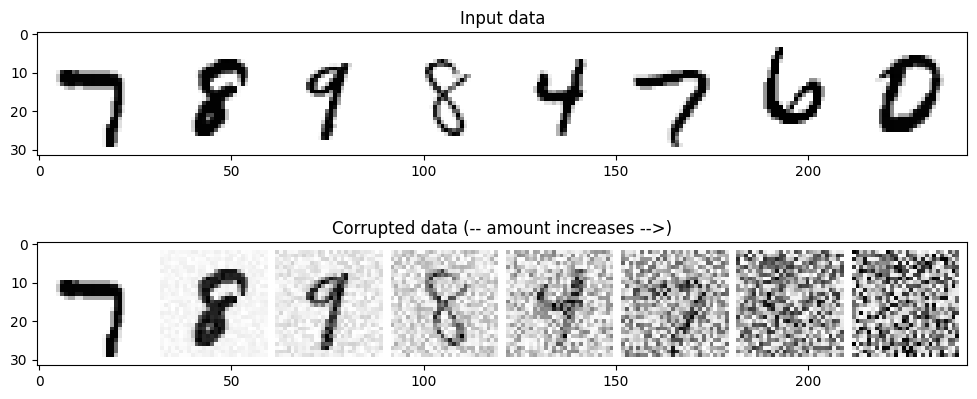

In [9]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
print(f"Amount ----> {amount}")
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

In [10]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )
        self.act = nn.SiLU()  # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))  # Through the layer and the activation function
            if i < 2:  # For all but the third (final) down layer:
                h.append(x)  # Storing output for skip connection
                x = self.downscale(x)  # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upscale
                x += h.pop()  # Fetching stored output (skip connection)
            x = self.act(l(x))  # Through the layer and the activation function

        return x

In [11]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

Finished epoch 0. Average loss for this epoch: 0.028265
Finished epoch 1. Average loss for this epoch: 0.021096
Finished epoch 2. Average loss for this epoch: 0.019103
Finished epoch 3. Average loss for this epoch: 0.018236
Finished epoch 4. Average loss for this epoch: 0.017503
Finished epoch 5. Average loss for this epoch: 0.016939
Finished epoch 6. Average loss for this epoch: 0.016773
Finished epoch 7. Average loss for this epoch: 0.016569
Finished epoch 8. Average loss for this epoch: 0.016165
Finished epoch 9. Average loss for this epoch: 0.016189


(0.0, 0.1)

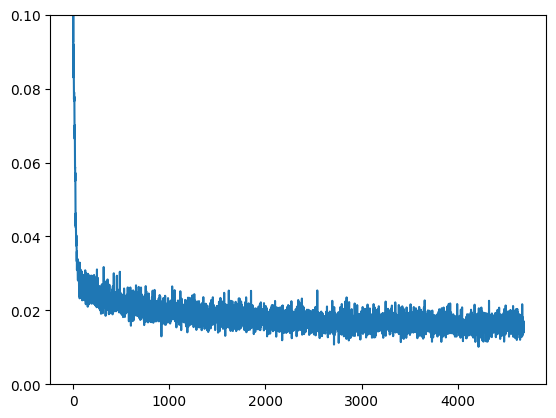

In [15]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device)  # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount)  # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x)  # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

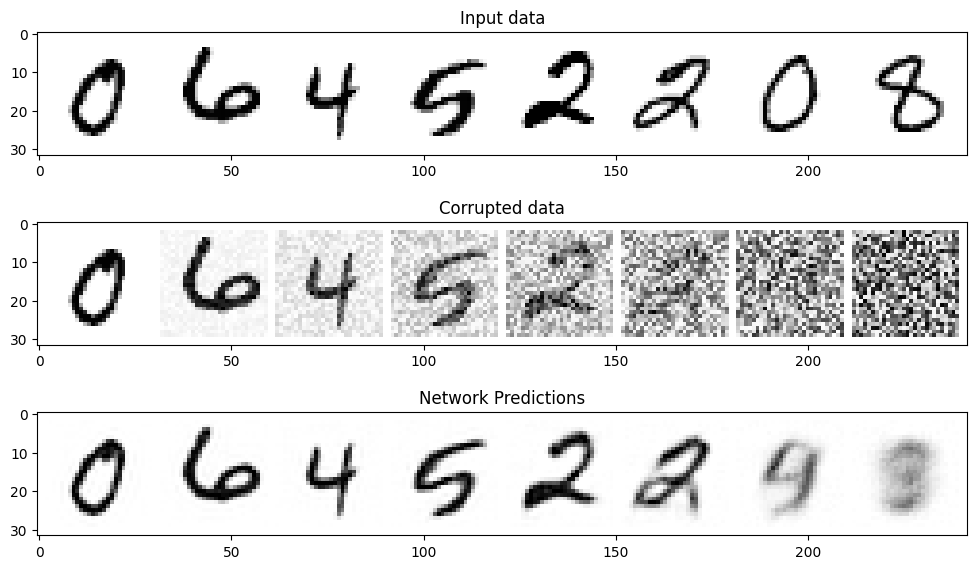

In [16]:
# @markdown Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8]  # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap="Greys")
axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap="Greys")

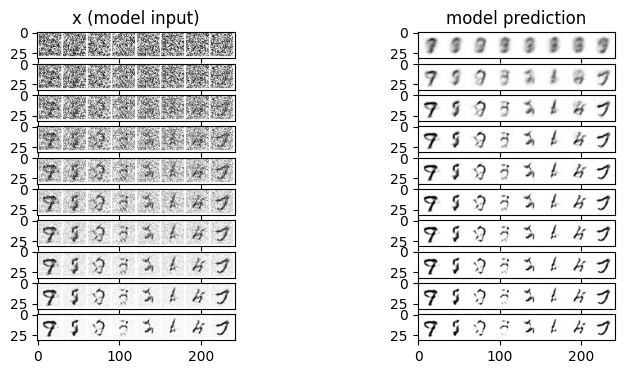

In [18]:
# @markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 10
x = torch.rand(8, 1, 28, 28).to(device)  # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():  # No need to track gradients during inference
        pred = net(x)  # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu())  # Store model output for plotting
    mix_factor = 1 / (n_steps - i)  # How much we move towards the prediction
    x = x * (1 - mix_factor) + pred * mix_factor  # Move part of the way there
    step_history.append(x.detach().cpu())  # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys")
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap="Greys")

#Class-Conditioned Diffusion Model
This is to illustrate one way to add conditioning information to a diffusion model. Specifically, we’ll train a class-conditioned diffusion model on MNIST where we can specify which digit we’d like the model to generate at inference time.

In [19]:
from tqdm.auto import tqdm

Input shape: torch.Size([128, 1, 28, 28])
Labels: tensor([8, 2, 7, 7, 0, 5, 4, 4, 5, 0, 0, 0, 2, 1, 0, 2, 5, 3, 7, 9, 2, 7, 1, 2,
        7, 6, 8, 7, 7, 9, 0, 5, 4, 4, 2, 4, 3, 0, 9, 7, 5, 2, 5, 7, 5, 7, 5, 9,
        9, 6, 5, 9, 4, 1, 3, 5, 6, 6, 3, 9, 0, 5, 1, 6, 5, 7, 1, 6, 1, 3, 9, 7,
        5, 2, 6, 7, 2, 2, 5, 1, 0, 9, 2, 1, 7, 5, 4, 3, 1, 7, 3, 5, 8, 9, 5, 9,
        4, 0, 5, 5, 7, 5, 1, 5, 5, 1, 6, 9, 0, 3, 3, 1, 7, 0, 7, 3, 4, 0, 5, 6,
        7, 9, 1, 6, 5, 2, 0, 8])


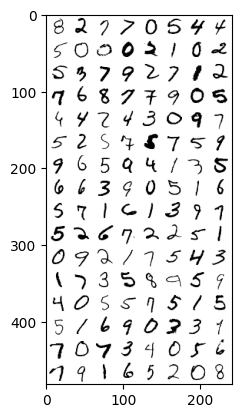

In [20]:
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

In [21]:
class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes=10, class_emb_size=4):
        super().__init__()

        # The embedding layer will map the class label to a vector of size class_emb_size
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
        self.model = UNet2DModel(
            sample_size=28,  # the target image resolution
            in_channels=1 + class_emb_size,  # Additional input channels for class cond.
            out_channels=1,  # the number of output channels
            layers_per_block=2,  # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",  # a regular ResNet downsampling block
                "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",  # a regular ResNet upsampling block
            ),
        )

    # Our forward method now takes the class labels as an additional argument
    def forward(self, x, t, class_labels):
        # Shape of x:
        bs, ch, w, h = x.shape

        # class conditioning in right shape to add as additional input channels
        class_cond = self.class_emb(class_labels)  # Map to embedding dimension
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
        # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

        # Net input is now x and class cond concatenated together along dimension 1
        net_input = torch.cat((x, class_cond), 1)  # (bs, 5, 28, 28)

        # Feed this to the UNet alongside the timestep and return the prediction
        return self.model(net_input, t).sample  # (bs, 1, 28, 28)

In [22]:
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.052927


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.046128


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.043199


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.043496


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.042130


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.039985


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.040018


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.039342


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 100 loss values: 0.039761


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 100 loss values: 0.038793


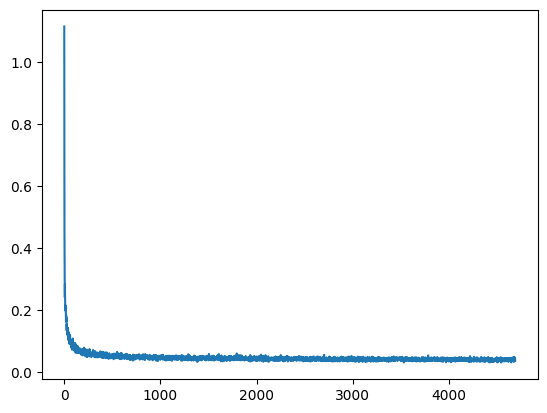

In [23]:
# @markdown Training loop (10 Epochs):

# Redefining the dataloader to set the batch size higher than the demo of 8
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our network
net = ClassConditionedUnet().to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1  # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y)  # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise)  # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:]) / 100
    print(f"Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}")

# View the loss curve
plt.plot(losses)

0it [00:00, ?it/s]

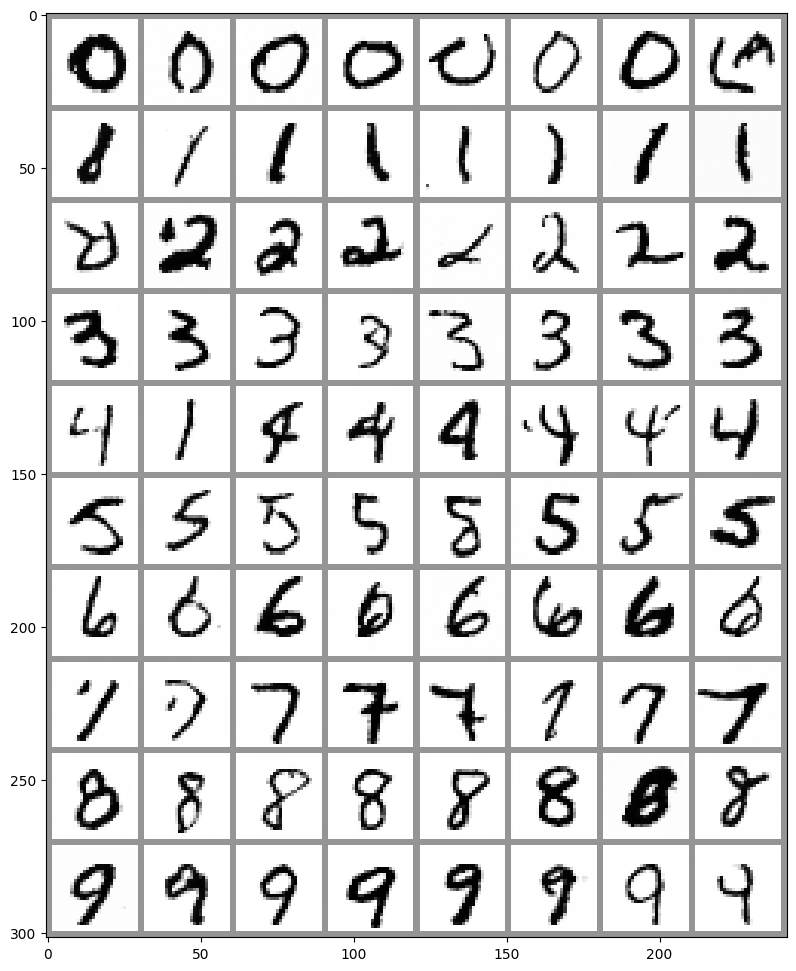

In [24]:
# @markdown Sampling some different digits:

# Prepare random x to start from, plus some desired labels y
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i] * 8 for i in range(10)]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = net(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap="Greys")